In [29]:
import numpy as np

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))

if path_ not in sys.path:
    sys.path.append(path_)
    
import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [31]:
import run_train_toy
importlib.reload(run_train_toy)
PyomoTrainerToy = run_train_toy.PyomoTrainerToy

data_params = {
    'N': 200,
    'noise_level': 0.2,
    'ode_type': "harmonic_oscillator",
    'data_param': {"omega_squared": 2},
    'start_time': 0,
    'end_time': 10,
    'spacing_type': "uniform",
    'initial_state': np.array([0.0, 1.0])
}

trainer = PyomoTrainerToy(data_params, model_type='jax_diffrax')
trainer.prepare_inputs()

In [32]:
import itertools

reg_list = [1e-5, 1e-4, 1e-3]
max_iter_li = [500, 1000, 1500]

param_combinations = list(itertools.product(reg_list, max_iter_li))

for c in param_combinations:
    print(str(c))
    print("reg:", c[0], "max_iter:", c[1])

(1e-05, 500)
reg: 1e-05 max_iter: 500
(1e-05, 1000)
reg: 1e-05 max_iter: 1000
(1e-05, 1500)
reg: 1e-05 max_iter: 1500
(0.0001, 500)
reg: 0.0001 max_iter: 500
(0.0001, 1000)
reg: 0.0001 max_iter: 1000
(0.0001, 1500)
reg: 0.0001 max_iter: 1500
(0.001, 500)
reg: 0.001 max_iter: 500
(0.001, 1000)
reg: 0.001 max_iter: 1000
(0.001, 1500)
reg: 0.001 max_iter: 1500


In [36]:
params_model = {
    'layer_widths': [2, 32, 32, 2],
    'penalty_lambda_reg': 1e-5,
    'time_invariant': True,
    'learning_rate': 1e-3,
    'max_iter': 1000,
    'pretrain': [0.2, 1],
    'pretrain': False,
    'verbose': False
}

results = {}
lw_list = [[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2], [2, 8, 8, 2], [2, 16, 16, 2], [2, 32, 32, 2], [2, 64, 64, 2]]
lw_list = [[2, 16, 2], [2, 32, 2], [2, 16, 16, 2], [2, 32, 32, 2]]
lw_list

total_iter = len(param_combinations)*len(lw_list)
i = 1

for lw in lw_list:
    params_model['layer_widths'] = lw
    results[str(lw)] = {}
    
    for param_comb in param_combinations:
      params_model['penalty_lambda_reg'] = param_comb[0]
      params_model['max_iter'] = param_comb[1]
      
      try:
        trainer.train(params_model)
      except Exception as e:
        logging.error("Failed to complete training: {}".format(e))
        continue
      
      result = trainer.extract_results()
      results[str(lw)][str(param_comb)] = result
      
      print("Iteration:", i, "/", total_iter)
      print(results[str(lw)][str(param_comb)]['mse_train'])
      print(results[str(lw)][str(param_comb)]['mse_test'])
      i+=1

Iteration: 1 / 36
0.3262873680277081
38.032072042269164
Iteration: 2 / 36
0.32417534610396764
47.57851353068948
Iteration: 3 / 36
0.3273842871854942
52.6441986517983
Iteration: 4 / 36
0.32560319404789817
40.469810561895386
Iteration: 5 / 36
0.3255149320741678
41.499469035869076
Iteration: 6 / 36
0.3247006791686451
45.99606219448478
Iteration: 7 / 36
0.3256874752271199
37.739296620021435
Iteration: 8 / 36
0.3248118810548344
40.977289496661314
Iteration: 9 / 36
0.32524583653768857
39.42075421666091
Iteration: 10 / 36
0.42661691521075484
1.0199080924141397
Iteration: 11 / 36
0.3655938190120422
1.4685059162901104
Iteration: 12 / 36
0.34858786352952414
1.5986266620360312
Iteration: 13 / 36
0.42667877094568496
1.0198322704823926
Iteration: 14 / 36
0.3656914455979986
1.4689719551581377
Iteration: 15 / 36
0.3487180656488711
1.597966668496386
Iteration: 16 / 36
0.42731320554084257
1.0190219763139698
Iteration: 17 / 36
0.3666817065600658
1.4736479933520994
Iteration: 18 / 36
0.3500315748863642
1

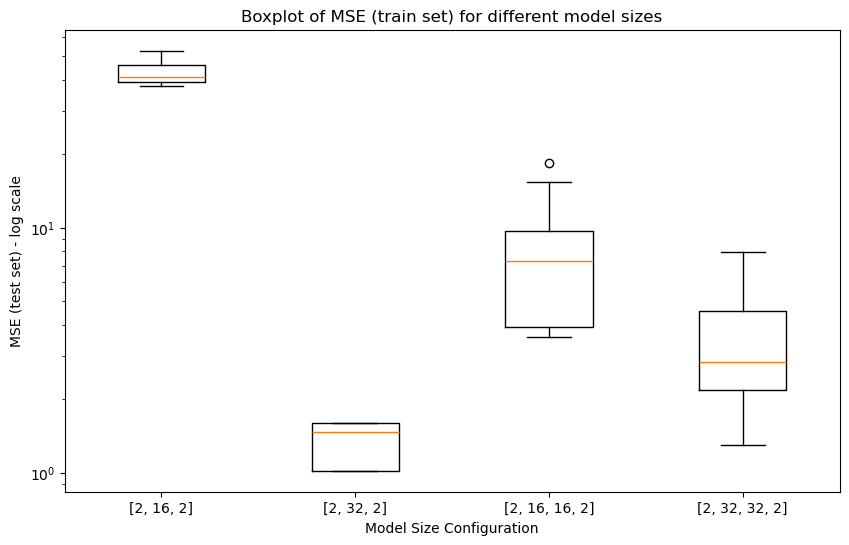

In [37]:
# box plots of accuracy and time elapsed for each layer width
# x axis: layer width
acc = []
time = []

for lw in results.keys():
    acc_temp = []
    time_temp = []
    for param_comb in results[lw].keys():
        acc_temp.append(results[lw][param_comb]['mse_test'].item())
        time_temp.append(results[lw][param_comb]['time_elapsed'])
        
    acc.append(acc_temp)
    time.append(time_temp)

plt.figure(figsize=(10, 6))
plt.boxplot(acc)

plt.title('Boxplot of MSE (train set) for different model sizes')
plt.xlabel('Model Size Configuration')
plt.ylabel('MSE (test set) - log scale')

labels = list(results.keys())
ticks = range(1, len(labels) + 1)
plt.xticks(ticks=ticks, labels=labels)

plt.yscale('log')
plt.show()

In [38]:
import run_train_toy
importlib.reload(run_train_toy)
PyomoTrainerToy = run_train_toy.PyomoTrainerToy
# ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}

data_params = {
    'N': 200,
    'noise_level': 0.2,
    'ode_type': "van_der_pol",
    'data_param': {"mu": 1, "omega": 1},
    'start_time': 0,
    'end_time': 10,
    'spacing_type': "uniform",
    'initial_state': np.array([0.0, 1.0])
}

trainer = PyomoTrainerToy(data_params, model_type='jax_diffrax')
trainer.prepare_inputs()

In [43]:
params_model = {
    'layer_widths': [2, 32, 32, 2],
    'penalty_lambda_reg': 1e-5,
    'time_invariant': True,
    'learning_rate': 1e-3,
    'max_iter': 1000,
    'pretrain': [0.2, 1],
    'verbose': False
}

results = {}
#lw_list = [[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2], [2, 8, 8, 2], [2, 16, 16, 2], [2, 32, 32, 2], [2, 64, 64, 2]]
lw_list = [[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 16, 16, 2], [2, 32, 32, 2], [2, 64, 64, 2]]
lw_list

total_iter = len(param_combinations)*len(lw_list)
i = 1

for lw in lw_list:
    params_model['layer_widths'] = lw
    results[str(lw)] = {}
    
    for param_comb in param_combinations:
      params_model['penalty_lambda_reg'] = param_comb[0]
      params_model['max_iter'] = param_comb[1]
      
      try:
        trainer.train(params_model)
      except Exception as e:
        logging.error("Failed to complete training: {}".format(e))
        continue
      
      result = trainer.extract_results()
      results[str(lw)][str(param_comb)] = result
      
      print("Iteration:", i, "/", total_iter)
      print(results[str(lw)][str(param_comb)]['mse_train'])
      print(results[str(lw)][str(param_comb)]['mse_test'])
      i+=1

Iteration: 1 / 54
2.376926697750577
12.015665298914248
Iteration: 2 / 54
2.302394052032161
19.69608625081036
Iteration: 3 / 54
2.288183922338459
21.48415048956893
Iteration: 4 / 54
2.3319912806967134
16.904839036825912
Iteration: 5 / 54
4.041862808639265
16.58522150113733
Iteration: 6 / 54
2.316470218006933
18.014140363359026
Iteration: 7 / 54
3.256605314312497
13.38612798673528
Iteration: 8 / 54
2.311843527441706
19.013700363210408
Iteration: 9 / 54
2.350625596950089
14.669562865332438
Iteration: 10 / 54
2.5662522175897617
17.05745363128496
Iteration: 11 / 54
2.492088168810991
19.47137280215942
Iteration: 12 / 54
2.420008643527358
19.163024717040297
Iteration: 13 / 54
2.566239757590507
17.06169546790173
Iteration: 14 / 54
2.487875285881212
20.425615933756628
Iteration: 15 / 54
2.4440299485415853
16.61272113454402
Iteration: 16 / 54
2.566053485735001
17.11594642579737
Iteration: 17 / 54
2.484217415712927
21.41623049173627
Iteration: 18 / 54
2.4266888618479725
19.603680088270263
Iterati

KeyboardInterrupt: 

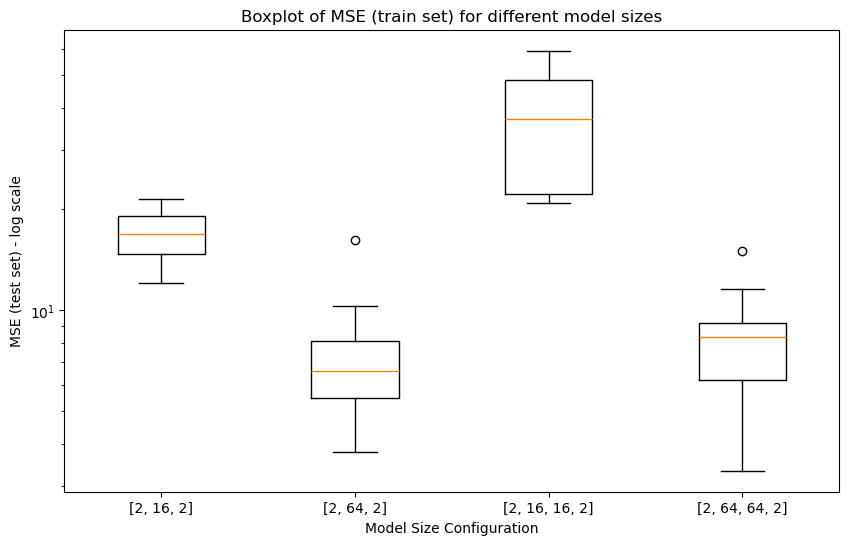

In [42]:
# box plots of accuracy and time elapsed for each layer width
# x axis: layer width
acc = []
time = []

for lw in results.keys():
    acc_temp = []
    time_temp = []
    for param_comb in results[lw].keys():
        acc_temp.append(results[lw][param_comb]['mse_test'].item())
        time_temp.append(results[lw][param_comb]['time_elapsed'])
        
    acc.append(acc_temp)
    time.append(time_temp)

plt.figure(figsize=(10, 6))
plt.boxplot(acc)

plt.title('Boxplot of MSE (train set) for different model sizes')
plt.xlabel('Model Size Configuration')
plt.ylabel('MSE (test set) - log scale')

labels = list(results.keys())
ticks = range(1, len(labels) + 1)
plt.xticks(ticks=ticks, labels=labels)

plt.yscale('log')
plt.show()